<h2> KNN Algorithm implementation over Amazon fine food reviews dataset</h2>

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from prettytable import PrettyTable


____Connecting to the Preprocessed SQLite database______

In [3]:
#Connecting to the SQL table
con = sqlite3.connect('final.sqlite')

#Reading data from the database

Data = pd.read_sql_query("""
SELECT *
FROM Reviews """,con)
Data.shape

(364171, 12)

In [4]:
# Drop index column
Data.drop(columns=['index'],inplace=True)


In [5]:
Data["Time"]=pd.to_datetime(Data.Time)
Data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1970-01-01 00:00:01.194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1970-01-01 00:00:01.191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1970-01-01 00:00:01.076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1970-01-01 00:00:01.018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [6]:
#Setting Time column as index of the dataframe 
Data.set_index("Time",inplace=True)

#Sampling the above data
Sorted=Data.sort_index()

In [7]:
Sorted.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,CleanedText
Time,,,,,,,,,,
1970-01-01 00:00:00.939340800,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1970-01-01 00:00:00.940809600,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
1970-01-01 00:00:00.944092800,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
1970-01-01 00:00:00.944438400,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
1970-01-01 00:00:00.946857600,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [8]:
#Sampling the above data

Sampled_data=Sorted.sample(n=20000,replace='False')
Sample_sort=Sampled_data.sort_index()
Sample_sort.shape


(20000, 10)

In [9]:
sampled_data=Sorted.sample(n=5000,replace='False')
mini_sort=sampled_data.sort_index()
mini_sort.shape


(5000, 10)

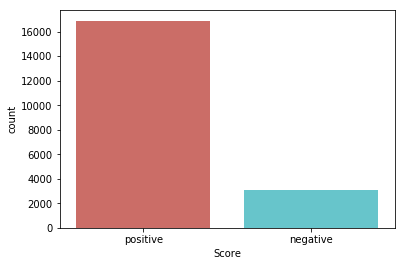

<Figure size 432x288 with 0 Axes>

In [10]:
label=mini_sort["Score"]
Class=Sample_sort["Score"]
sns.countplot(x="Score",data=Sample_sort,palette="hls")
plt.show()
plt.savefig("count_plot")


In [11]:
#Dropping the Score column which are the actual class labels of the dataset
mini_sort.drop(columns=['Score'],inplace=True)
mini_sort.shape

(5000, 9)

In [12]:
#Dropping the Score column from the sampled_set which are the actual class labels of the dataset
Sample_sort.drop(columns=['Score'],inplace=True)
Sample_sort.shape

(20000, 9)

<h2>Observations</h2>
<ul>
    <li>Here after all the text-preprocesing and the data-cleaning only 364k datapoints remained.</li>
    <li>I have taken a sample size of 20k out of the total population for the purpose of analyzing and studying the behaviour of the data by applying the K-nearest neighbour algorithm.</li>
    <li>First I took the "TIME" column and set as the index of the new sampled dataframe and then sorted accordingly in ascending order since the data has a temporal nature.</li>
    <li>By setting the "SCORE" column as a class label for classifying the reviews as a positive and negative.</li>
    <li>By observing the above bar plot it is clear that the above dataset is highly imbalanced and this may cause problems in the future analysis.</li>
</ul>
   

<h3>Splitting the data into 80:20 partitions sets</h3>

In [13]:
def data_split(x,y):
    #Splitting the model into 80:30 split of Training and test split
    X_tr, X_test, y_tr, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False,random_state=None)


    return X_tr,y_tr,X_test,y_test

<h3>Preparing the data for further use</h3>

In [14]:

X=Sample_sort
Y=Class

X_tr,y_tr,X_test,y_test=data_split(X,Y)

print("The shape of x_train is:",X_tr.shape)
print("the shape of y_train is:",y_tr.shape)
print("the shape of x_test is:",X_test.shape)
print("the shape of y_test is:",y_test.shape)

The shape of x_train is: (16000, 9)
the shape of y_train is: (16000,)
the shape of x_test is: (4000, 9)
the shape of y_test is: (4000,)


<h3>Preparing the data for applying the kd-tree approach</h3>

In [25]:
X_1=mini_sort
Y_1=label

X_train,X_Test,y_train,y_Test=train_test_split(X_1, Y_1, test_size=0.2,shuffle=False,random_state=None)

print("The shape of x_train is:",X_train.shape)
print("the shape of y_train is:",y_train.shape)
print("the shape of x_test is:",X_Test.shape)
print("the shape of y_test is:",y_Test.shape)

The shape of x_train is: (4000, 9)
the shape of y_train is: (4000,)
the shape of x_test is: (1000, 9)
the shape of y_test is: (1000,)


<h3>Utility functions for training the models</h3>

In [37]:
#Function for Training the model

def train (X_tr,y_tr,X_test,y_test,algo):

    for i in range(1,30,2):
    # instantiate learning model (k = 30)
        knn = KNeighborsClassifier(n_neighbors=i,algorithm=algo,n_jobs= -1)

    # fitting the model on crossvalidation train
        knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
        pred = knn.predict(X_test)

    # evaluate CV accuracy
        acc = accuracy_score(y_test, pred, normalize=True) * float(100)
        print('\n The train accuracy for k = %d is %d%%' % (i, acc))
    
    
########################################################################################

#Function for performing the crossvalidation technique
# creating odd list of K for KNN
def crossval(X_tr,y_tr,alg="auto"):
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
    cv_scores = []

# perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k,algorithm=alg,n_jobs= -1)
        scores = cross_val_score(knn, X_tr, y_tr, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())
    return cv_scores,neighbors

##################################################################################################        

#Function for plotting the error plot 

def errorplot(cv_scores,neighbors):

# changing to misclassification error
    MSE = [1 - x for x in cv_scores]

# determining best k
    optimal_k1 = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k1)

# plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()
    print("the misclassification error for each k value is : ", np.round(MSE,3))
    return optimal_k1

##############################################################################################################

#Function for finding the Test accuracy using the best k vaue 
    
def Optimal_test(X_train,y_train,X_test,y_test,optimal_k,alg="auto"):    
# instantiate learning model k = optimal_k
    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm=alg,n_jobs= -1)

# fitting the model
    knn_optimal.fit(X_train, y_train)

# predict the response
    pred = knn_optimal.predict(X_test)

# evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
    return pred,acc



<h3>Utility functions for plotting the confusion matrix</h3>

In [19]:

from sklearn.metrics import confusion_matrix
def Confusion_metric(y_test,y_pred,acc):
    print(metrics.confusion_matrix(y_test,y_pred))
    confusion=metrics.confusion_matrix(y_test,y_pred)

    plt.figure(figsize=(9,9))
    sns.heatmap(confusion, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Predicted label');
    plt.xlabel('Actual label');
    all_sample_title = 'Accuracy Score: {0}'.format( acc)
    plt.title(all_sample_title, size = 15);
    plt.show()

#Storing the values of the confusion matrix
    TN=confusion[0,0]
    FP=confusion[0,1]
    FN=confusion[1,0]
    TP=confusion[1,1]

# use float to perform true division, not integer division
    Class_acc=((TP + TN) / float(TP + TN + FP + FN))*100

#Code for classification error

    classification_error = ((FP + FN) / float(TP + TN + FP + FN))*100
    

#Code for finding the TPR,FPR,TNR,FNR

    TPR = (TP / float(FN + TP))*100

    FNR = (FN / float(FN + TP))*100

    TNR=(TN / float(TN + FP))*100

    FPR=(FP / float(TN + FP))*100
    
#Code for finding the Precision,Recall & F1_score    
   
    precision = (TP/float(TP+FP))*100
    
    recall= (TP / float(FN + TP))*100
    
    F1_s= ((float(precision*recall)/float(precision+recall))*2)
    
    print()
    
    ptable=PrettyTable()
    ptable.title="The performance metrics of the above model are as follows: "
    ptable.field_names=["Metrics","Scores"]
    ptable.add_row(["Classification_accuracy",Class_acc])
    ptable.add_row(["Classification_error",classification_error])
    ptable.add_row(["True positive",TP])
    ptable.add_row(["False positive",FP])
    ptable.add_row(["True negative",TN])
    ptable.add_row(["False negative",FN])
    ptable.add_row(["True positive rate",TPR])
    ptable.add_row(["False negative rate",FNR])
    ptable.add_row(["True negative rate",TNR])
    ptable.add_row(["False positive rate",FPR])
    ptable.add_row(["Precision value",precision])
    ptable.add_row(["Recall value",recall])
    ptable.add_row(["f1_score value",F1_s])
    
    print(ptable)
    

<h3>Utilty functions for vectorizing the data</h3>

In [20]:
#Function for vectorizing the train data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler(with_mean=False)


def vec_train(vect,X_tr):
    import warnings
    warnings.filterwarnings("ignore")

    count_vect = vect #in scikit-learn
    BOW = count_vect.fit_transform(X_tr.values)

#Standardizing the vectorized data
    standardized_data = scaler.fit_transform(BOW)
    standardized_data.shape
    return count_vect,standardized_data


#Function for vectorizing the CV data

def vec_cv(count,X_cv):
    cv=count.transform(X_cv.values)
    cv.get_shape()

    std_cv=scaler.transform(cv)
    std_cv.shape
    return std_cv


#Function for vectorizing the test data

def vec_test(count,X_test):
    test=count.transform(X_test.values)
    test.get_shape()

    std_data=scaler.transform(test)
    std_data.shape
    return std_data

#Funtion for printing the total number of top features
def top_tfidf_feats(name,row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', name]
    return df




<h3>Bag of words implementation of the data</h3>

In [21]:
#Initializing the count vectorizer 
Count_vect=CountVectorizer(binary=True)

#vectorizing the X_train set
count,x_tr=vec_train(Count_vect,X_tr["CleanedText"])

print("The shape of the X_train is: ",x_tr.shape)

#Vectorizing the X_test set
x_test=vec_test(count,X_test["CleanedText"])
print("The shape of the X_test is: ",x_test.shape)


#Printing the total length of the features
print("\nTop 25 feaures acording to the Bow score are as follows")
features = Count_vect.get_feature_names()
len(features)


top_Bow = top_tfidf_feats("bow",x_tr[1,:].toarray()[0],features,25)
top_Bow




The shape of the X_train is:  (16000, 15959)
The shape of the X_test is:  (4000, 15959)

Top 25 feaures acording to the Bow score are as follows


,feature,bow
0,efect,126.495059
1,winona,73.036522
2,ryder,63.253460
3,cartoon,56.577383
4,hilari,56.577383
5,film,33.820970
6,danc,33.820970
7,shown,19.315686
8,hey,18.477783
9,funni,17.740594


<h3>Training the KNN model over BOW implemented data</h3>

In [40]:
##Preparing the data

train(x_tr,y_tr,x_test,y_test,"brute")



 The train accuracy for k = 1 is 78%

 The train accuracy for k = 3 is 81%

 The train accuracy for k = 5 is 82%

 The train accuracy for k = 7 is 82%

 The train accuracy for k = 9 is 82%

 The train accuracy for k = 11 is 82%

 The train accuracy for k = 13 is 82%

 The train accuracy for k = 15 is 82%

 The train accuracy for k = 17 is 82%

 The train accuracy for k = 19 is 82%

 The train accuracy for k = 21 is 82%

 The train accuracy for k = 23 is 82%

 The train accuracy for k = 25 is 82%

 The train accuracy for k = 27 is 82%

 The train accuracy for k = 29 is 82%


____Finding the best Hyperparameter using the Cross-validation technique_____

In [49]:
#FINDING THE 10 FOLD ACCURACY OVER THE CROSS-VALIDATION SET 
cv,neigh=crossval(x_tr,y_tr,"brute")


The optimal number of neighbors is 7.


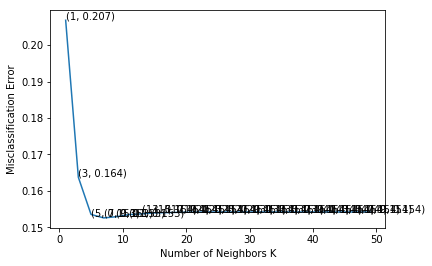

the misclassification error for each k value is :  [0.207 0.164 0.153 0.153 0.153 0.153 0.154 0.154 0.154 0.154 0.154 0.154
 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154
 0.154]


In [50]:
#FINDING THE OPTIMAL VALUE 
Optimal_k= errorplot(cv,neigh)


_____Finding the Test accuracy using the best K value_____

In [51]:
y_Pre,Acc=Optimal_test(x_tr,y_tr,x_test,y_test,Optimal_k,"brute")


The accuracy of the knn classifier for k = 7 is 82.433333%


[[  34 1033]
 [  21 4912]]


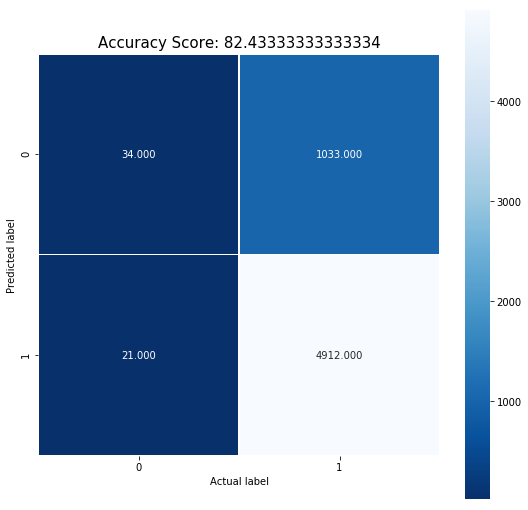


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     82.43333333333334     |
|       Classification_error      |     17.566666666666666    |
|          True positive          |            4912           |
|          False positive         |            1033           |
|          True negative          |             34            |
|          False negative         |             21            |
|        True positive rate       |     99.57429556051085     |
|       False negative rate       |    0.42570443948915465    |
|        True negative rate       |     3.1865042174320526    |
|       False positive rate       |     96.81349578256795     |
|         Precision value         |    

In [52]:
Confusion_metric(y_test,y_Pre,Acc)

<h2>Observations</h2>
<ul>
    <li>The train accuracy of the above model is 82% at 7 as a optimal value.</li>
    <li>But after analyzing the confusion matrix the model is not sensible at all because the True positive value is dominating so as the TPR values as compared to the other metrics.
    <li>The True negative and the False negative rates are very miniscule which leads to decreased TNR and increased FNR which is very bad for a classification model.</li>
    <li>The model is not at all clssiffying the negative reviews and the model is really dumb.</li>
    <li>The model is facing a very heavy bias problem and underfitting a lot.</li>
    <li>So accuracy as a metric cannot be trusted in a imbalanced dataset, the model's performance may improve if we use another approach such as:-</li>
        <ul>
            <li>1)KD-tree approach.</li>
            <li>2)Oversampling techniques.</li>
        </ul>
 </ul>
   
       
    

<h3>Implementing the count vectorizer for applying kd-tree method</h3> 

In [26]:
#Initializing the count vectorizer 
Count_vect=CountVectorizer(binary=True)

#vectorizing the X_train set
Coun,bow_tra=vec_train(Count_vect,X_train["CleanedText"])

print("The shape of the X_train is: ",bow_tra.shape)

#Vectorizing the X_test set
bow_tes=vec_test(Coun,X_Test["CleanedText"])
print("The shape of the X_test is: ",bow_tes.shape)


#Printing the total length of the features
print("\nTop 25 feaures acording to the Bow score are as follows")
feature = Count_vect.get_feature_names()
len(feature)


Top_Bow = top_tfidf_feats("bow",bow_tra[1,:].toarray()[0],feature,25)
Top_Bow




The shape of the X_train is:  (4000, 8720)
The shape of the X_test is:  (1000, 8720)

Top 25 feaures acording to the Bow score are as follows


,feature,bow
0,melitta,31.638600
1,overpow,11.055335
2,lemon,9.481575
3,hint,9.183979
4,life,7.969709
5,recent,6.974274
6,addit,6.343647
7,instead,5.792413
8,expect,5.517877
9,green,5.149618


<h3>KD-TREE implementation of the KNN-model</h3>

In [27]:
#Creating the dense representation of the Train and Test sets 

Dense_tr=bow_tra.todense(order="C")
Dense_te=bow_tes.todense(order="C")

<h3>Training the model using the kd-tree approach</h3>

In [29]:
train(Dense_tr,y_train,Dense_te,y_Test,"kd_tree")


 The train accuracy for k = 1 is 79%

 The train accuracy for k = 3 is 81%

 The train accuracy for k = 5 is 81%

 The train accuracy for k = 7 is 82%

 The train accuracy for k = 9 is 82%

 The train accuracy for k = 11 is 82%

 The train accuracy for k = 13 is 82%

 The train accuracy for k = 15 is 82%

 The train accuracy for k = 17 is 82%

 The train accuracy for k = 19 is 82%

 The train accuracy for k = 21 is 82%

 The train accuracy for k = 23 is 82%

 The train accuracy for k = 25 is 82%

 The train accuracy for k = 27 is 82%

 The train accuracy for k = 29 is 82%


<h3> Hyperparameter tuning & plotting error metric the above model for finding the right K</h3>

In [30]:
#FINDING THE 10 FOLD ACCURACY OVER THE CROSS-VALIDATION SET 
kdcv,kdneigh=crossval(Dense_tr,y_train,"kd_tree")


The optimal number of neighbors is 5.


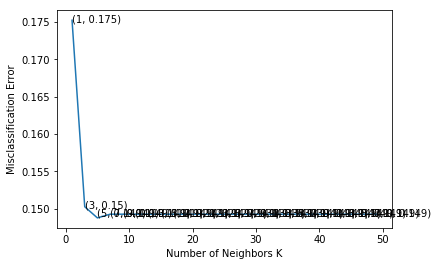

the misclassification error for each k value is :  [0.175 0.15  0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149
 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149
 0.149]


In [31]:
#FINDING THE OPTIMAL VALUE 
Kd_Optimal_k= errorplot(kdcv,kdneigh)


<h3> Testing the above model over the test set</h3>

In [33]:
kd_y_Pre,kd_Acc=Optimal_test(Dense_tr,y_train,Dense_te,y_Test,Kd_Optimal_k,"kd_tree")


The accuracy of the knn classifier for k = 5 is 81.900000%


<h3>Confusion matrix of the above model</h3>

[[  0 179]
 [  2 819]]


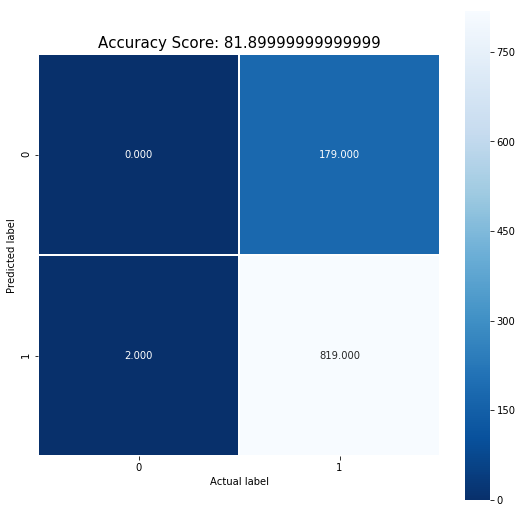


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     81.89999999999999     |
|       Classification_error      |     18.099999999999998    |
|          True positive          |            819            |
|          False positive         |            179            |
|          True negative          |             0             |
|          False negative         |             2             |
|        True positive rate       |      99.7563946406821     |
|       False negative rate       |    0.24360535931790497    |
|        True negative rate       |            0.0            |
|       False positive rate       |           100.0           |
|         Precision value         |    

In [34]:
Confusion_metric(y_Test,kd_y_Pre,kd_Acc)

<h2>Observations</h2>
<ul>
    <li>First I took a small sample of points(5K)for the implementation of kd_tree and converted the sparse representation to dense because Kd-tree works on dense matrix.</li>
    <li>Even after applying the Kd-tree approach and tuning the hyperparameter the model's accuracy and performance didn't changed and the model still underfitts</li>
    <li>Lets try Oversampling the data and try to run all the model diagnostics to see model improvements in terms of stability and accuracy.</li>
        

<h3>function for Oversampling the data by using the Synthetic minority oversampling technique (SMOTE).</h3>

In [51]:
#FUNCTION FOR IMPLEMENTING THE SYNTHETIC MINORITY OVERSAMPLING TECHNIQUE
from imblearn.over_sampling import SMOTE 

def Bal_train (X_tr, y_tr,X_test,y_test,algo="auto"):
  
    sm = SMOTE()
    X_Train_res, y_Train_res = sm.fit_sample(X_tr, y_tr)
    
    X_Test_res,y_Test_res=sm.fit_sample(X_test,y_test)
    
    
    for i in range(1,30,2):
    # instantiate learning model (k = 30)
        knn = KNeighborsClassifier(n_neighbors=i,algorithm=algo,n_jobs= -1)

    # fitting the model on crossvalidation train
        knn.fit(X_Train_res,y_Train_res)

    # predict the response on the crossvalidation train
        pred = knn.predict( X_Test_res)

    # evaluate CV accuracy
        acc = accuracy_score(y_Test_res, pred, normalize=True) * float(100)
        print('\n The train accuracy for k = %d is %d%%' % (i, acc))
    
    
    return X_Train_res, y_Train_res,X_Test_res,y_Test_res



<h3>Training the KNN model over the Oversampled data.</h3>

In [59]:
X_btr,y_btr,X_btest,y_btest=Bal_train(x_tr,y_tr,x_test,y_test,"brute")


 The train accuracy for k = 1 is 66%

 The train accuracy for k = 3 is 66%

 The train accuracy for k = 5 is 67%

 The train accuracy for k = 7 is 65%

 The train accuracy for k = 9 is 63%

 The train accuracy for k = 11 is 61%

 The train accuracy for k = 13 is 59%

 The train accuracy for k = 15 is 58%

 The train accuracy for k = 17 is 57%

 The train accuracy for k = 19 is 55%

 The train accuracy for k = 21 is 54%

 The train accuracy for k = 23 is 53%

 The train accuracy for k = 25 is 53%

 The train accuracy for k = 27 is 52%

 The train accuracy for k = 29 is 52%


<h3>Hyperparameter tuning the above model for finding the optimal K</h3>

In [60]:
#FINDING THE 10 FOLD ACCURACY OVER THE CROSS-VALIDATION SET 
balcv,balneigh=crossval(X_btr,y_btr,"brute")


The optimal number of neighbors is 1.


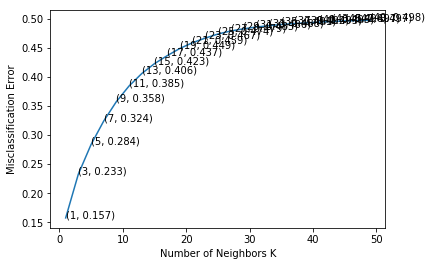

the misclassification error for each k value is :  [0.157 0.233 0.284 0.324 0.358 0.385 0.406 0.423 0.437 0.449 0.459 0.467
 0.474 0.479 0.483 0.486 0.488 0.491 0.492 0.493 0.495 0.496 0.497 0.497
 0.498]


In [61]:
#FINDING THE OPTIMAL VALUE 
Bal_Optimal_k= errorplot(balcv,balneigh)


<h3>Testing the model over the test data</h3>

In [63]:
bal_y_Pre,bal_Acc=Optimal_test(X_btr,y_btr,X_btest,y_btest,Bal_Optimal_k,"brute")


The accuracy of the knn classifier for k = 1 is 66.146361%


<h3>Confusion matrix of the above model</h3>

[[3126 1807]
 [1533 3400]]


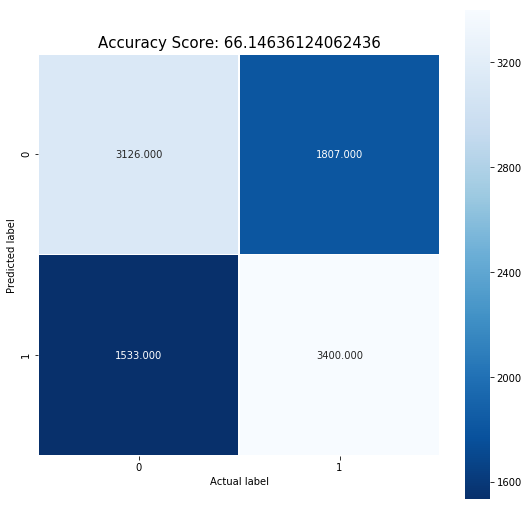


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     66.14636124062436     |
|       Classification_error      |     33.853638759375634    |
|          True positive          |            3400           |
|          False positive         |            1807           |
|          True negative          |            3126           |
|          False negative         |            1533           |
|        True positive rate       |     68.92357591729171     |
|       False negative rate       |     31.076424082708293    |
|        True negative rate       |     63.369146563957024    |
|       False positive rate       |     36.630853436042976    |
|         Precision value         |    

In [67]:
Confusion_metric(y_btest,bal_y_Pre,bal_Acc)

<h2>Observations</h2>
<ul>
    <li>The Test accuracy of the model is around 66.14% which is quite low for a classification model.</li>
    <li>The optimal K value is 1 which means the model overfitts which reduces the model performance.</li>
    <li>The Performance metrics are quite good as compared to the previous unbalanced model inspite of the low accuracy of the classification model.</li>
    <li>The True Positive and the True negative values are good as compared to the other 2 values</li>
    <li>The main reason the low accuracy is because of considerable FNR and FPR values which is quite alarming.</li>
    <li>Here the model is overfitting but still the model is stable as compared to the previous models</li>
    
        
        


<h2>Implementing Tf-idf vectorization technique and finding the top 25 features </h2>

In [18]:
#Initializing the count vectorizer 
TF_vect=TfidfVectorizer(ngram_range=(1,2),binary=True)

#vectorizing the X_train set
TF_count,X_tra=vec_train(TF_vect,X_tr["CleanedText"])

print("The shape of the X_train is: ",X_tra.shape)


#Vectorizing the X_test set
X_tes=vec_test(TF_count,X_test["CleanedText"])
print("The shape of the X_test is: ",X_tes.shape)


#Printing the total length of the features
print("\nTop 25 feaures acording to the Bow score are as follows")
Features = TF_vect.get_feature_names()
len(Features)


top_tfidf = top_tfidf_feats("tfidf",X_tra[1,:].toarray()[0],Features,25)
top_tfidf




The shape of the X_train is:  (24000, 446329)
The shape of the X_test is:  (6000, 446329)

Top 25 feaures acording to the Bow score are as follows


,feature,tfidf
0,especi fun,154.922561
1,season cooki,154.922561
2,event birthday,154.922561
3,shade ice,154.922561
4,fun event,154.922561
5,tabl decor,154.922561
6,ice martha,154.922561
7,event past,154.922561
8,easili blend,154.922561
9,tea event,154.922561


<h3> KNN (Brute force) implementation of the above data</h3>

In [83]:
train(X_tr,y_tr,X_test,y_test,"brute")


 The train accuracy for k = 1 is 17%

 The train accuracy for k = 3 is 82%

 The train accuracy for k = 5 is 82%

 The train accuracy for k = 7 is 82%

 The train accuracy for k = 9 is 82%

 The train accuracy for k = 11 is 82%

 The train accuracy for k = 13 is 82%

 The train accuracy for k = 15 is 82%

 The train accuracy for k = 17 is 82%

 The train accuracy for k = 19 is 82%

 The train accuracy for k = 21 is 82%

 The train accuracy for k = 23 is 82%

 The train accuracy for k = 25 is 82%

 The train accuracy for k = 27 is 82%

 The train accuracy for k = 29 is 82%


In [84]:
#FINDING THE 10 FOLD ACCURACY OVER THE CROSS-VALIDATION SET 
TFcv,TFneigh=crossval(X_tr,y_tr,"brute")


The optimal number of neighbors is 5.


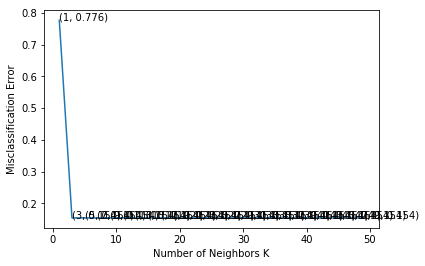

the misclassification error for each k value is :  [0.776 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154
 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154
 0.154]


In [85]:
#FINDING THE OPTIMAL VALUE 
TF_Optimal_k= errorplot(TFcv,TFneigh)


<h3>Testing the model over the test data</h3>

In [86]:
TF_y_Pre,TF_Acc=Optimal_test(X_tr,y_tr,X_test,y_test,TF_Optimal_k,"brute")


The accuracy of the knn classifier for k = 5 is 82.216667%


<h3>Confusion matrix of the above model</h3>

[[   0 1067]
 [   0 4933]]


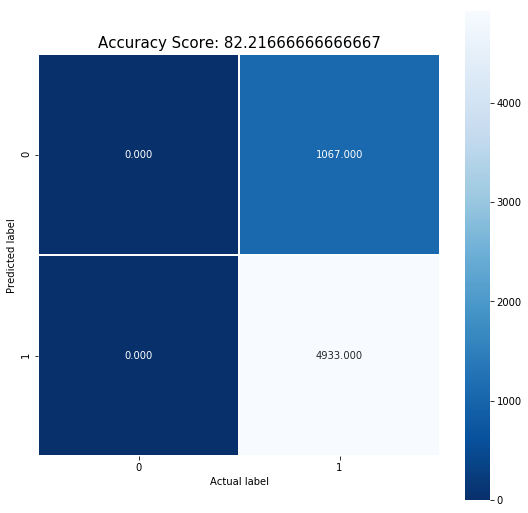


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     82.21666666666667     |
|       Classification_error      |     17.783333333333335    |
|          True positive          |            4933           |
|          False positive         |            1067           |
|          True negative          |             0             |
|          False negative         |             0             |
|        True positive rate       |           100.0           |
|       False negative rate       |            0.0            |
|        True negative rate       |            0.0            |
|       False positive rate       |           100.0           |
|         Precision value         |    

In [87]:
Confusion_metric(y_test,TF_y_Pre,TF_Acc)

<h3>Observation</h3>
<ul>
    <li>The above model has a accuracy of 82.21% but still the model is completely dumb.</li>
    <li>By studying the confusion matrix it is clear that the model has a very severe bias problem.</li>
    <li>Only the positive class labels are dominating and we can see a FPR equal to 100% so the model is clearly neglecting or missclassiffying the negative reviews.</li>
    <li>Lets explore other techniques in which the performance of the model may improve.</li>
    

<h3>Implementing the Tf-idf vectorizer for applying the kd-tree method</h3> 

In [36]:
#Initializing the count vectorizer 
Tf_vect=TfidfVectorizer(ngram_range=(1,2),binary=True)

#vectorizing the X_train set
TF_coun,tfidf_tra=vec_train(Tf_vect,X_train["CleanedText"])

print("The shape of the X_train is: ",tfidf_tra.shape)


#Vectorizing the X_test set
tfidf_tes=vec_test(TF_coun,X_Test["CleanedText"])
print("The shape of the X_test is: ",tfidf_tes.shape)


#Printing the total length of the features
print("\nTop 25 feaures acording to the Bow score are as follows")
TF_Features = Tf_vect.get_feature_names()
len(TF_Features)


Top_tfidf = top_tfidf_feats("tfidf",tfidf_tra[1,:].toarray()[0],TF_Features,25)
Top_tfidf




The shape of the X_train is:  (4000, 114026)
The shape of the X_test is:  (1000, 114026)

Top 25 feaures acording to the Bow score are as follows


,feature,tfidf
0,coffe instead,63.253460
1,expect love,63.253460
2,life far,63.253460
3,perfect addit,63.253460
4,bought melitta,63.253460
5,melitta expect,63.253460
6,lemon perfect,63.253460
7,favorit hint,63.253460
8,instead love,63.253460
9,hint lemon,55.595564


<h3>Creating dense matrix representation of the tf-idf vectorized data.</h3>

In [58]:
Dense_tra=tfidf_tra.todense(order="C")
Dense_tes=tfidf_tes.todense(order="C")

<h3>KD-TREE implementation of the KNN-model</h3>

In [59]:
train(Dense_tra,y_train,Dense_tes,y_Test,"kd_tree")


 The train accuracy for k = 1 is 82%

 The train accuracy for k = 3 is 82%

 The train accuracy for k = 5 is 82%

 The train accuracy for k = 7 is 82%

 The train accuracy for k = 9 is 82%

 The train accuracy for k = 11 is 82%

 The train accuracy for k = 13 is 82%

 The train accuracy for k = 15 is 82%

 The train accuracy for k = 17 is 82%

 The train accuracy for k = 19 is 82%

 The train accuracy for k = 21 is 82%

 The train accuracy for k = 23 is 82%

 The train accuracy for k = 25 is 82%

 The train accuracy for k = 27 is 82%

 The train accuracy for k = 29 is 82%


In [60]:
TFkdcv,TFkdneigh=crossval(Dense_tra,y_train,"kd_tree")

<h3>Hyperparameter tuning for finding the optimal k</h3>


The optimal number of neighbors is 1.


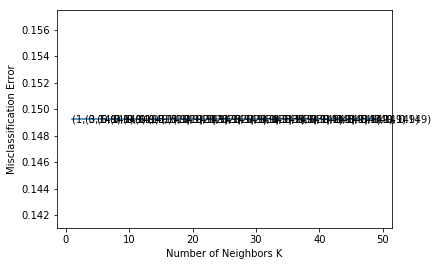

the misclassification error for each k value is :  [0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149
 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149
 0.149]


In [61]:
#FINDING THE OPTIMAL VALUE 
TFkd_Optimal_k= errorplot(TFkdcv,TFkdneigh)


<h3>Testing the model over the test data</h3>

In [62]:
TFkd_y_Pre,TFkd_Acc=Optimal_test(Dense_tra,y_train,Dense_tes,y_Test,TFkd_Optimal_k,"kd_tree")


The accuracy of the knn classifier for k = 1 is 82.100000%


<h3>Confusion matrix of the above model</h3>

[[  0 179]
 [  0 821]]


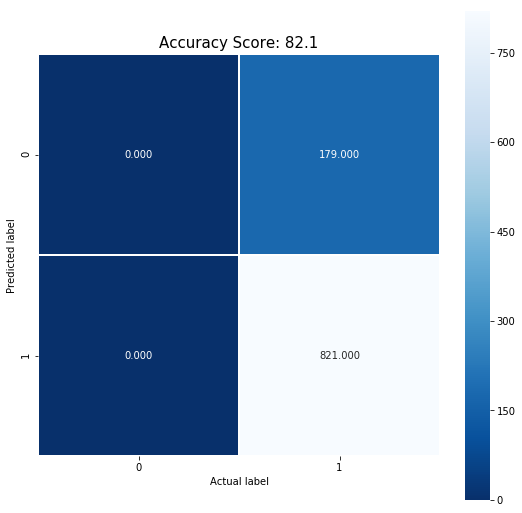


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+----------------------------------+--------------------------+
|             Metrics              |          Scores          |
+----------------------------------+--------------------------+
|     Classification_accuracy      |           82.1           |
|       Classification_error       |           17.9           |
|          True positive           |           821            |
|          False positive          |           179            |
|          True negative           |            0             |
|          False negative          |            0             |
|        True positive rate        |          100.0           |
|       False negative rate        |           0.0            |
|        True negative rate        |           0.0            |
|       False positive rate        |          100.0           |
|         Precision value          |   

In [63]:
Confusion_metric(y_Test,TFkd_y_Pre,TFkd_Acc)

<h2>Observations</h2>
<ul>
    <li>To implement the Kd_tree approch it took me about (17-Hrs) to complete it on 5K points since the matrix was dense and this approach is very computationally expensive.</li> 
    <li>The model is still dumb and no differnce is seen in this approach so this technique do not add any value to the model.</li>
    <li>Bias problem is still there and the model is still underfitting and lets try to solve the problem by oversampling it.</li>
    <li>Since the kd_tree was implemented on 5k datapoints and still it gave the same performance of the 20K points(Brute) approach so if the Kd_tree(KNN) model is trained over larger datapoints the perrformance might increase.</li>
    <li>In the Tf-idf vectorized KNN model the effect of Curse of dimensionality is seen.</li>

<h3> Oversampling the data by using the Synthetic minority oversampling technique (SMOTE).</h3>

In [94]:
X_Btr,y_Btr,X_Btest,y_Btest=Bal_train(Dense_tra,y_tr,x_test,y_test,"brute")


 The train accuracy for k = 1 is 67%

 The train accuracy for k = 3 is 67%

 The train accuracy for k = 5 is 67%

 The train accuracy for k = 7 is 65%

 The train accuracy for k = 9 is 63%

 The train accuracy for k = 11 is 61%

 The train accuracy for k = 13 is 59%

 The train accuracy for k = 15 is 58%

 The train accuracy for k = 17 is 56%

 The train accuracy for k = 19 is 55%

 The train accuracy for k = 21 is 54%

 The train accuracy for k = 23 is 53%

 The train accuracy for k = 25 is 53%

 The train accuracy for k = 27 is 52%

 The train accuracy for k = 29 is 52%



The optimal number of neighbors is 5.


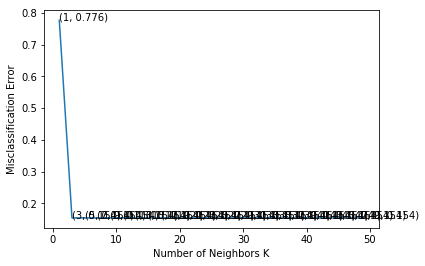

the misclassification error for each k value is :  [0.776 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154
 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154
 0.154]


In [96]:
#FINDING THE OPTIMAL VALUE 
TFB_Optimal_k= errorplot(TFBcv,TFBneigh)


<h3>Testing the model over the test data</h3>

In [97]:
TFB_y_Pre,TFB_Acc=Optimal_test(X_tr,y_tr,X_test,y_test,TFB_Optimal_k,"brute")


The accuracy of the knn classifier for k = 5 is 82.216667%


<h3>Confusion matrix of the above model</h3>

[[   0 1067]
 [   0 4933]]


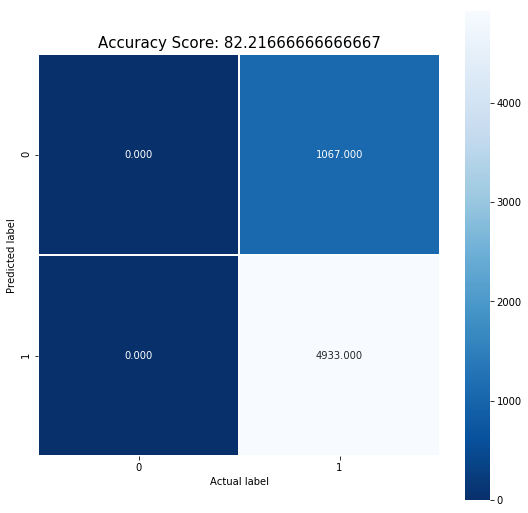


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     82.21666666666667     |
|       Classification_error      |     17.783333333333335    |
|          True positive          |            4933           |
|          False positive         |            1067           |
|          True negative          |             0             |
|          False negative         |             0             |
|        True positive rate       |           100.0           |
|       False negative rate       |            0.0            |
|        True negative rate       |            0.0            |
|       False positive rate       |           100.0           |
|         Precision value         |    

In [98]:
Confusion_metric(y_test,TFB_y_Pre,TFB_Acc)

<h2>Observations</h2>
<ul>
    <li>Even after oversampling the datapoints there is no improvements seen in the model and still it is dumb.<li>
    <li>Since the Tf-idf vectorizer has high dimensions and KNN-Algorithm do not work well with this type of data so may be there is a problem of "Curse of dimensionality".</li>
    <li>Let's try two other vectorization techniques which are:-</li>
        <ol>
            <li>Avg W2V technique.</li>
            <li>Tf-idf weighted W2V technique</li>
        </ol>
                
        

<h2>Implementing the Average word to vectorization technique.</h2>

In [19]:
start = datetime.now()
import gensim

# Train our own Word2Vec model using text corpus
list_of_sentence_vec=[]
for sentence in Sample_sort['CleanedText'].values:
    list_of_sentence_vec.append(sentence.split())
# Generate model.
w2v_Model = gensim.models.Word2Vec(list_of_sentence_vec,min_count=5,size=50, workers=6)

w2v_Words = list(w2v_Model.wv.vocab)
print("number of words that occured minimum 5 times is ",len(w2v_Words))


#code for finding the avg w2v
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_Model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    #print(np.isnan(np.sum(sent_vec)))
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

print('Time taken :', datetime.now() - start)

number of words that occured minimum 5 times is  7526
30000
50
Time taken : 0:00:08.588583


<h3>Training the K-NN model by using Avg-Word to vector.</h3>

In [20]:
X=sent_vectors
Y=Class

X_w2vtr, X_w2vtes, y_w2vtr, y_w2vtes = train_test_split(X, Y, test_size=0.2,shuffle=False,random_state=None)


In [21]:
train(X_w2vtr,y_w2vtr,X_w2vtes,y_w2vtes,"brute")


 The train accuracy for k = 1 is 81%

 The train accuracy for k = 3 is 84%

 The train accuracy for k = 5 is 84%

 The train accuracy for k = 7 is 85%

 The train accuracy for k = 9 is 85%

 The train accuracy for k = 11 is 85%

 The train accuracy for k = 13 is 85%

 The train accuracy for k = 15 is 85%

 The train accuracy for k = 17 is 85%

 The train accuracy for k = 19 is 85%

 The train accuracy for k = 21 is 85%

 The train accuracy for k = 23 is 85%

 The train accuracy for k = 25 is 85%

 The train accuracy for k = 27 is 85%

 The train accuracy for k = 29 is 85%


<h3>Hyperparameter tuning the above model to find the right k.</h3>

In [22]:
w2vcv,w2vneigh=crossval(X_w2vtr,y_w2vtr,"brute")


The optimal number of neighbors is 19.


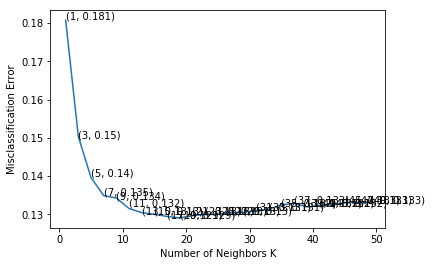

the misclassification error for each k value is :  [0.181 0.15  0.14  0.135 0.134 0.132 0.13  0.13  0.129 0.129 0.13  0.13
 0.13  0.13  0.13  0.131 0.131 0.132 0.133 0.132 0.132 0.132 0.133 0.133
 0.133]


In [23]:
#FINDING THE OPTIMAL VALUE 
w2v_Optimal_k= errorplot(w2vcv,w2vneigh)


<h3>Testing the model over the test set</h3>

In [24]:
w2v_y_Pre,w2v_Acc=Optimal_test(X_w2vtr,y_w2vtr,X_w2vtes,y_w2vtes ,w2v_Optimal_k,"brute")


The accuracy of the knn classifier for k = 19 is 85.400000%


<h3>Plotting the confusion matrix of the above model</h3>

[[ 216  816]
 [  60 4908]]


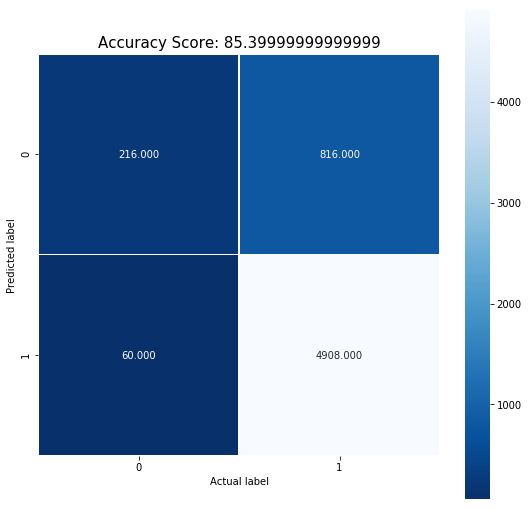


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     85.39999999999999     |
|       Classification_error      |            14.6           |
|          True positive          |            4908           |
|          False positive         |            816            |
|          True negative          |            216            |
|          False negative         |             60            |
|        True positive rate       |     98.79227053140096     |
|       False negative rate       |     1.2077294685990339    |
|        True negative rate       |     20.930232558139537    |
|       False positive rate       |     79.06976744186046     |
|         Precision value         |    

In [25]:
Confusion_metric(y_w2vtes,w2v_y_Pre,w2v_Acc)

<h2>Observation</h2>

<ul>
    <li>The train accuracy of the above model is 85.39% at 19 as a optimal value.</li>
    <li>But after analyzing the confusion matrix the model is not sensible at all because the True positive value is dominating so as the TPR values as compared to the other metrics.
    <li>The True negative and the False negative rates are very miniscule which leads to decreased TNR and increased FNR which is very bad for a classification model.</li>
    <li>The model is classifying the negative reviews very badly and the model is really dumb.</li>
    <li>The model is facing a very heavy bias problem and underfitting a lot.</li>
    <li>So accuracy as a metric cannot be trusted in a imbalanced dataset, the model's performance may improve if we use another approach such as:-</li>
        <ul>
            <li>1)KD-tree approach.</li>
            <li>2)Oversampling techniques.</li>
        </ul>
 </ul

<h3> Oversampling the data by using the Synthetic minority oversampling technique (SMOTE).</h3>

In [27]:
train_X,train_Y,test_X,test_Y=Bal_train (X_w2vtr,y_w2vtr,X_w2vtes,y_w2vtes,"brute")


 The train accuracy for k = 1 is 72%

 The train accuracy for k = 3 is 73%

 The train accuracy for k = 5 is 74%

 The train accuracy for k = 7 is 74%

 The train accuracy for k = 9 is 74%

 The train accuracy for k = 11 is 74%

 The train accuracy for k = 13 is 75%

 The train accuracy for k = 15 is 75%

 The train accuracy for k = 17 is 75%

 The train accuracy for k = 19 is 75%

 The train accuracy for k = 21 is 75%

 The train accuracy for k = 23 is 75%

 The train accuracy for k = 25 is 75%

 The train accuracy for k = 27 is 75%

 The train accuracy for k = 29 is 75%


<h3>Hyperparameter tuning the above model to find the right k.</h3>

In [28]:
W2vcv,W2vneigh=crossval(train_X,train_Y,"brute")


The optimal number of neighbors is 1.


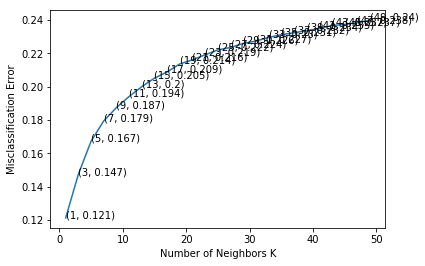

the misclassification error for each k value is :  [0.121 0.147 0.167 0.179 0.187 0.194 0.2   0.205 0.209 0.214 0.216 0.219
 0.222 0.224 0.226 0.227 0.23  0.231 0.232 0.234 0.235 0.237 0.237 0.238
 0.24 ]


In [29]:
#FINDING THE OPTIMAL VALUE 
W2v_Optimal_k= errorplot(W2vcv,W2vneigh)


<h3>Testing the model over the test set</h3>

In [31]:
W2v_y_Pre,W2v_Acc=Optimal_test(train_X,train_Y,test_X,test_Y,W2v_Optimal_k,"brute")


The accuracy of the knn classifier for k = 1 is 72.051127%


<h3>Confusion matrix of the above model</h3>

[[3305 1663]
 [1114 3854]]


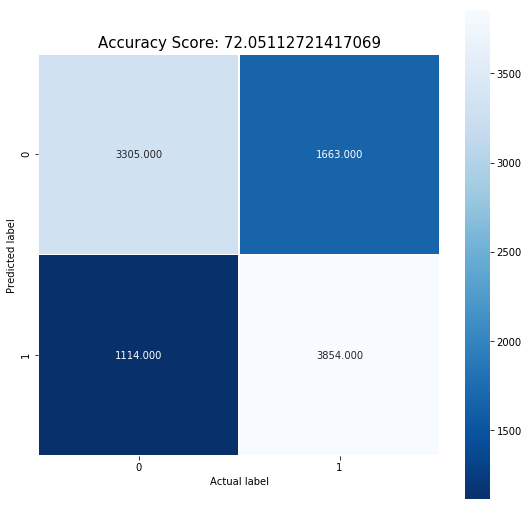


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     72.05112721417069     |
|       Classification_error      |     27.94887278582931     |
|          True positive          |            3854           |
|          False positive         |            1663           |
|          True negative          |            3305           |
|          False negative         |            1114           |
|        True positive rate       |     77.57648953301127     |
|       False negative rate       |     22.423510466988727    |
|        True negative rate       |     66.52576489533011     |
|       False positive rate       |     33.47423510466989     |
|         Precision value         |    

In [32]:
Confusion_metric(test_Y,W2v_y_Pre,W2v_Acc)

<h2>Observations</h2>
<ul>
    <li>The Test accuracy of the model is around 72.05% which is quite low for a classification model.</li>
    <li>The optimal K value is 1 which means the model overfitts which reduces the model performance.</li>
    <li>The Performance metrics are quite good as compared to the previous unbalanced model inspite of the low accuracy of the classification model.</li>
    <li>The True Positive value is good as compared to the True negative</li>
    <li>The main reason the low accuracy is because of considerable FNR and FPR values which is quite alarming.</li>
    <li>Here the model is overfitting but still the model is stable as compared to the previous models</li>
  

<h2>Implementing Tf-idf weighted word to vector technique</h2>

In [51]:
start = datetime.now()

Tfidf_vector=TfidfVectorizer()
Tf_model=Tfidf_vector.fit_transform(Sample_sort["CleanedText"].values)

Dimension=Tfidf_vector.get_feature_names() 

LIST_VECTOR=[]
row=0
for sentence in list_of_sentence_vec:
    word_2_vec=np.zeros(50)
    weight_tf_sum=0
    for word in sentence:
        try:
            vec=w2v_Model.wv[word]
            tfidf_value=Tf_model[row,Dimension.index(word)]
            word_2_vec += (vec* tfidf_value)
            weight_tf_sum += tfidf_value
        except:
            pass
    if weight_tf_sum !=0:
        word_2_vec /=weight_tf_sum
    LIST_VECTOR.append(word_2_vec)
    row += 1
    
print('Time taken :', datetime.now() - start)

Time taken : 0:03:34.863762


<h3>Training the knn model over the TF-idf weighted W2V implemented vector</h3> 

In [35]:
X1=LIST_VECTOR
Y1=Class

X_tfw2v, X_tfw2vtes, y_tfw2vtr, y_tfw2vtes = train_test_split(X1, Y1, test_size=0.2,shuffle=False,random_state=None)


In [39]:
train(X_tfw2v,y_tfw2vtr, X_tfw2vtes,y_tfw2vtes ,"brute")


 The train accuracy for k = 1 is 79%

 The train accuracy for k = 3 is 82%

 The train accuracy for k = 5 is 83%

 The train accuracy for k = 7 is 84%

 The train accuracy for k = 9 is 84%

 The train accuracy for k = 11 is 84%

 The train accuracy for k = 13 is 84%

 The train accuracy for k = 15 is 84%

 The train accuracy for k = 17 is 84%

 The train accuracy for k = 19 is 84%

 The train accuracy for k = 21 is 84%

 The train accuracy for k = 23 is 84%

 The train accuracy for k = 25 is 84%

 The train accuracy for k = 27 is 84%

 The train accuracy for k = 29 is 84%


<h3>Hyperparameter tuning the above model to find the right k.</h3>

In [40]:
tfw2vcv,tfw2vneigh=crossval(X_tfw2v,y_tfw2vtr,"brute")


The optimal number of neighbors is 31.


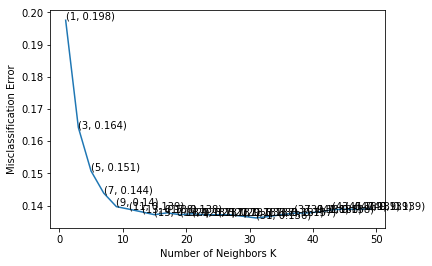

the misclassification error for each k value is :  [0.198 0.164 0.151 0.144 0.14  0.139 0.138 0.137 0.138 0.137 0.137 0.137
 0.137 0.137 0.137 0.136 0.137 0.137 0.138 0.138 0.138 0.139 0.139 0.139
 0.139]


In [41]:
#FINDING THE OPTIMAL VALUE 
tfw2v_Optimal_k= errorplot(tfw2vcv,tfw2vneigh)


<h3>Testing the model over the test set</h3>

In [42]:
tfw2v_y_Pre,tfw2v_Acc=Optimal_test(X_tfw2v,y_tfw2vtr, X_tfw2vtes,y_tfw2vtes,tfw2v_Optimal_k,"brute")


The accuracy of the knn classifier for k = 31 is 84.516667%


<h3>Confusion matrix of the above model</h3>

[[ 149  883]
 [  46 4922]]


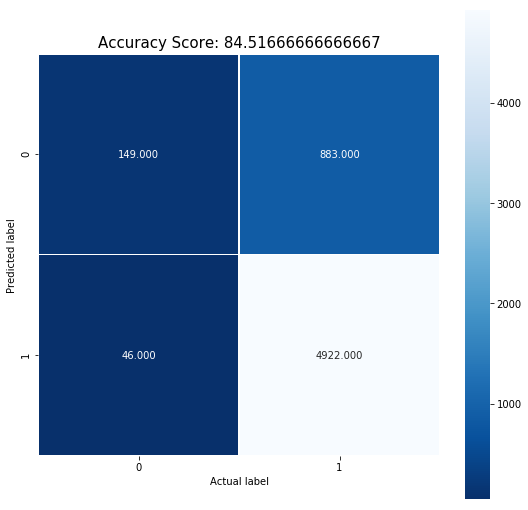


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     84.51666666666667     |
|       Classification_error      |     15.483333333333333    |
|          True positive          |            4922           |
|          False positive         |            883            |
|          True negative          |            149            |
|          False negative         |             46            |
|        True positive rate       |     99.07407407407408     |
|       False negative rate       |     0.9259259259259258    |
|        True negative rate       |     14.437984496124031    |
|       False positive rate       |     85.56201550387597     |
|         Precision value         |    

In [43]:
Confusion_metric(y_tfw2vtes,tfw2v_y_Pre,tfw2v_Acc)

<h2>Observations</h2>
<ul>
    <li>The train accuracy of the above model is 84.51% at 31 as a optimal value.</li>
    <li>But after analyzing the confusion matrix the model is not sensible at all because the True positive value is dominating so as the TPR values as compared to the other metrics.
    <li>The True negative and the False negative rates are very miniscule which leads to decreased TNR which is very bad for a classification model.</li>
    <li>The model is not at all classiffying the negative reviews and the model is really dumb.</li>
    <li>The model is facing a very heavy bias problem and underfitting a lot since the optimal k value is 31.</li>
    <li>So accuracy as a metric cannot be trusted in a imbalanced dataset, the model's performance may improve if we use another approach such as:-</li>
        <ul>
            <li>1)KD-tree approach.</li>
            <li>2)Oversampling techniques.</li>
        </ul>
 </ul

<h2>Oversampling the datapoints by using the SMOTE technique.</h2>

In [44]:
Train_x,Train_y,Test_x,Test_y=Bal_train (X_tfw2v,y_tfw2vtr, X_tfw2vtes,y_tfw2vtes,"brute")


 The train accuracy for k = 1 is 68%

 The train accuracy for k = 3 is 71%

 The train accuracy for k = 5 is 72%

 The train accuracy for k = 7 is 72%

 The train accuracy for k = 9 is 72%

 The train accuracy for k = 11 is 72%

 The train accuracy for k = 13 is 72%

 The train accuracy for k = 15 is 72%

 The train accuracy for k = 17 is 72%

 The train accuracy for k = 19 is 72%

 The train accuracy for k = 21 is 72%

 The train accuracy for k = 23 is 72%

 The train accuracy for k = 25 is 72%

 The train accuracy for k = 27 is 72%

 The train accuracy for k = 29 is 72%


<h3>Hyperparameter tuning the above model to find the right k.</h3>

In [46]:
TFW2vcv,TFW2vneigh=crossval(Train_x,Train_y,"brute")


The optimal number of neighbors is 1.


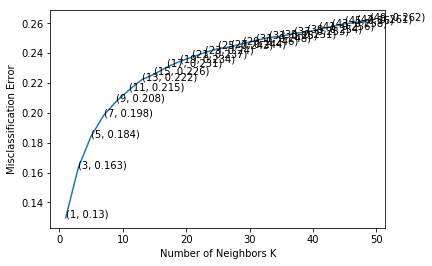

the misclassification error for each k value is :  [0.13  0.163 0.184 0.198 0.208 0.215 0.222 0.226 0.231 0.234 0.237 0.24
 0.243 0.244 0.246 0.248 0.25  0.251 0.253 0.254 0.256 0.258 0.26  0.261
 0.262]


In [47]:
#FINDING THE OPTIMAL VALUE 
TFW2v_Optimal_k= errorplot(TFW2vcv,TFW2vneigh)


<h3>Testing the model over the test set</h3>

In [48]:
TFW2v_y_Pre,TFW2v_Acc=Optimal_test(Train_x,Train_y,Test_x,Test_y,W2v_Optimal_k,"brute")


The accuracy of the knn classifier for k = 1 is 68.357488%


<h3>Confusion matrix of the above model</h3>

[[3021 1947]
 [1197 3771]]


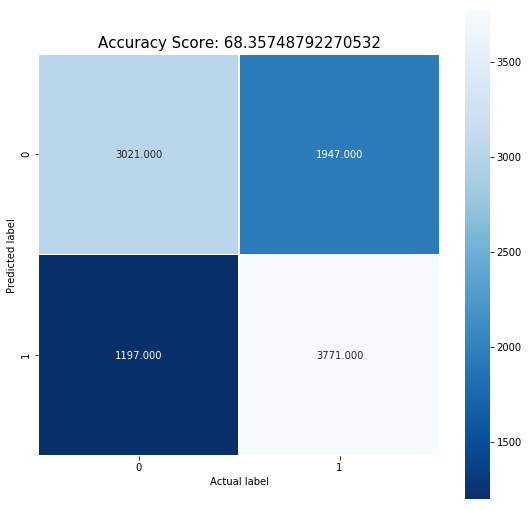


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     68.35748792270532     |
|       Classification_error      |     31.642512077294686    |
|          True positive          |            3771           |
|          False positive         |            1947           |
|          True negative          |            3021           |
|          False negative         |            1197           |
|        True positive rate       |     75.90579710144928     |
|       False negative rate       |     24.094202898550723    |
|        True negative rate       |     60.809178743961354    |
|       False positive rate       |     39.190821256038646    |
|         Precision value         |    

In [50]:
Confusion_metric(Test_y,TFW2v_y_Pre,TFW2v_Acc)

<h2>Observations</h2>
<ul>
    <li>The Test accuracy of the model is around 68.35% which is quite low for a classification model.</li>
    <li>The optimal K value is 1 which means the model overfitts which reduces the model performance.</li>
    <li>The Performance metrics are quite good as compared to the previous unbalanced model inspite of the low accuracy of the classification model.</li>
    <li>The True Positive value is good as compared to the True negative.</li>
    <li>The main reason the low accuracy is because of considerable FNR and FPR values which is quite alarming.</li>
    <li>Here the model is overfitting but still the model is stable and sensible as compared to the previous models.</li>
  

<h2>Conclusion:-</h2>
<ul>
    <li>So by implementing all the four techniques of vectorization I have come to these conclusions:-</li>
        <ol>
            <li>The results in both the approachs with Kd-tree and Brute are not that much similar and the Kd_tree method may yield better results if trained on larger datapoints.</li>
            <li>The Knn-algorithm suffers from curse of dimensionality specially with tf-idf vectorization technique and Dense Kd_tree implementation.</li>
            <li>The KNN-model overfits and underfitts easily if the model is trained over an Imbalanced datasets and accuracy as a metric cannot be trusted completely.</li>
            <li>The Kd_tree approach is very much computationally expensive and time consuming.</li>
            <li>The usage of Synthetic minority oversampling technique (SMOTE) is usefull in imbalanced text data as it made the models stable as compared to the imbalanced datasets but it overfitts easily.</li>
            <li>From my observations I can conclude that KNN-algorithm does not work well with the text data due to high dimensions.</li>
        </ol>
